In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../")

from experiment import Exp

from dataloaders import data_set,data_dict
import torch
import yaml
import os

# 参数设置

# 训练参数 
除了路径 其他不要变

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = dotdict()   
# TODO change the path as relative path
# args.to_save_path     = r"E:\TECO_Works\Conference\ISWC2022\Run_logs"              
# args.freq_save_path   = r"E:\TECO_Works\Conference\ISWC2022\Freq_data"
# args.window_save_path = r"E:\TECO_Works\Conference\ISWC2022\Sliding_window"
# args.root_path        = r"E:\datasets"

args.to_save_path     = "/pfs/data5/home/kit/tm/px6680/Conference/ISWC2023/Run_logs"              
args.freq_save_path   = "/pfs/data5/home/kit/tm/px6680/Conference/ISWC2023/Freq_data"
args.window_save_path = "/pfs/data5/home/kit/tm/px6680/Conference/ISWC2023/Sliding_window"
args.root_path        = "/pfs/data5/home/kit/tm/px6680/datasets"


args.drop_transition  = False
args.datanorm_type    = "standardization" # None ,"standardization", "minmax"


args.batch_size       = 256                                                     
args.shuffle          = True
args.drop_last        = False
args.train_vali_quote = 0.90                                           


# training setting 
args.train_epochs            = 150

args.learning_rate           = 0.001  
args.learning_rate_patience  = 7
args.learning_rate_factor    = 0.1


args.early_stop_patience     = 15

args.use_gpu                 = True if torch.cuda.is_available() else False
args.gpu                     = 0
args.use_multi_gpu           = False

args.optimizer               = "Adam"
args.criterion               = "CrossEntropy"

## 数据参数



In [7]:
args.seed                             = 1


args.data_name                        =  "hapt"

args.wavelet_filtering                = False
args.wavelet_filtering_regularization = False
args.wavelet_filtering_finetuning     = False
args.wavelet_filtering_finetuning_percent = 0.5
args.wavelet_filtering_learnable      = False
args.wavelet_filtering_layernorm      = False

args.regulatization_tradeoff          = 0
args.number_wavelet_filtering         = 6


# 是否作augmentation difference
args.difference          =  True 

# 是否作augmentation  filtering
args.filtering           =  True

# 是否作augmentation  magnitude
args.magnitude           =  False
args.weighted_sampler    = False



# MIXUP
args.mixup_probability  = 0.5
args.mixup_alpha  = 0.5


# Random Augmentation
args.random_augmentation_prob = 0.5
args.random_augmentation_config = {"jitter":True,
                                   "moving_average":True,
                                   "magnitude_scaling":True,
                                   "magnitude_warp":True,
                                   "magnitude_shift":True,
                                   "time_warp":True,
                                   "window_warp":True,
                                   "window_slice":True,
                                   "random_sampling":True,
                                   "slope_adding":True
                                   }
random_augmentation_nr = 0
for key in args.random_augmentation_config.keys():
    if args.random_augmentation_config[key]:
        random_augmentation_nr = random_augmentation_nr+1
args.random_augmentation_nr = random_augmentation_nr
args.max_aug = 3

args.pos_select       = None
args.sensor_select    = None


args.representation_type = "time"
args.exp_mode            = "LOCV"
if args.data_name      ==  "skodar":
    args.exp_mode            = "SOCV"
    
config_file = open('../../configs/data.yaml', mode='r')
data_config = yaml.load(config_file, Loader=yaml.FullLoader)
config = data_config[args.data_name]

args.root_path       = os.path.join(args.root_path,config["filename"])
args.sampling_freq   = config["sampling_freq"]
args.num_classes     =  config["num_classes"]
window_seconds       = config["window_seconds"]
args.windowsize      =   int(window_seconds * args.sampling_freq) 
args.input_length    =  args.windowsize
# input information
args.c_in            =  config["num_channels"]
print(args.c_in )
if args.difference:
    args.c_in  = args.c_in * 2
    print(args.c_in )
if  args.filtering :
    for col in config["sensors"]:
        if "acc" in col:
            args.c_in = args.c_in+1
            print(args.c_in )


if args.wavelet_filtering :
    
    if args.windowsize%2==1:
        N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
    else:
        N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

    args.f_in            =  args.number_wavelet_filtering*N_ds+1
else:
    args.f_in            =  1



6
12
13
14
15


## 模型参数

In [8]:
args.num_classes

12

In [9]:
args.filter_scaling_factor = 1
args.model_type              = "deepconvlstm"#"deepconvlstm"#"sahar" #"deepconvlstm"
exp = Exp(args)
exp.model

Use GPU: cuda:0
Build the DeepConvLSTM model!
Done!
Parameter : 31382
Set the seed as :  1


model_builder(
  (model): DeepConvLSTM(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (conv1): Conv2d(1, 14, kernel_size=(5, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(14, 14, kernel_size=(5, 1), stride=(2, 1))
      )
      (1): ConvBlock(
        (conv1): Conv2d(14, 14, kernel_size=(5, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(14, 14, kernel_size=(5, 1), stride=(2, 1))
      )
    )
    (lstm_layers): ModuleList(
      (0): LSTM(210, 29, batch_first=True)
    )
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=29, out_features=12, bias=True)
  )
)

In [37]:
# cross_channel_interaction_type = "attn",    # attn  transformer  identity
# cross_channel_aggregation_type = "filter",  # filter  naive  FC  "SFCC", "SFCF"
# temporal_info_interaction_type = "gru",     # gru  lstm  attn  transformer  identity  conv
# temporal_info_aggregation_type = "FC",      # naive  filter  FC  tnaive

# 实验

In [11]:
# 如果我们设置为 


args.model_type              = "tinyhar"#"deepconvlstm"#"sahar" #"deepconvlstm"

args.cross_channel_interaction_type = "attn"
args.cross_channel_aggregation_type = "FC"
args.temporal_info_interaction_type = "lstm"
args.temporal_info_aggregation_type = "tnaive"

exp = Exp(args)

Use GPU: cuda:0
Build the TinyHAR model!
Done!
Parameter : 348110
Set the seed as :  1


In [1]:
exp.model

NameError: name 'exp' is not defined

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------
================ LOCV Mode ====================
================ 10 CV ======================
================ the 0 th CV Experiment ================ 
Leave one Out Experiment : The 1 Part as the test
[-] Target sampling weights:  [0.0001465  0.000181   0.00097182 0.00123001 0.0004852  0.00060716]
Train data number :  17901
The number of classes is :  6
The input_length  is :  100
The channel_in is :  3
Validation data number :  1989
Test data number :  9947
================ Build the model ================ 
Build the TinyHAR model!
Epoch: 1 cost time: 5.367213487625122
VALI: Epoch: 1, Steps: 70 | Train Loss: 1.0914069  Vali Loss: 0.6358299 Vali Accuracy: 0.7772750  Vali weighted F1: 0.7174540  Vali macro F1 0.4970725 
Validation loss decreased (inf --> 0.635830).  Saving model

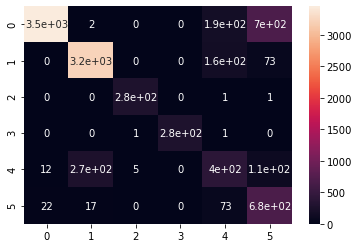

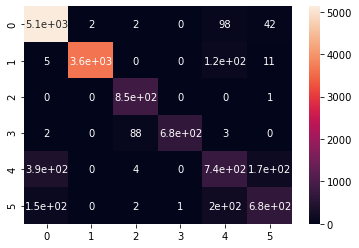

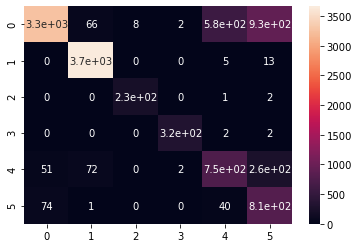

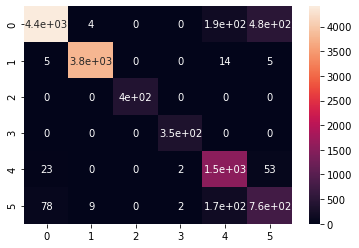

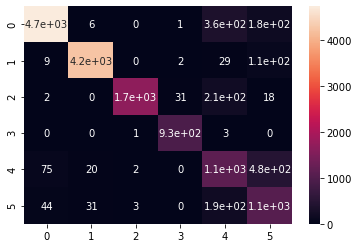

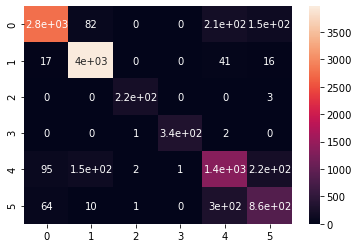

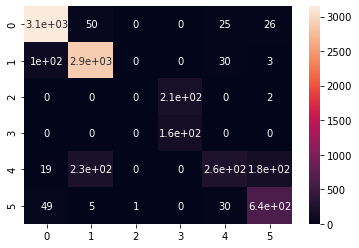

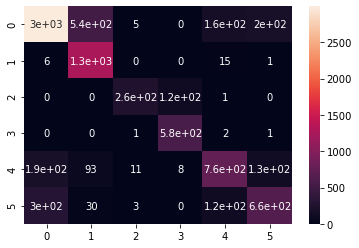

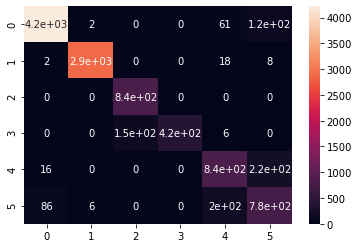

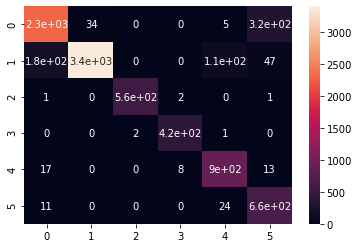

In [24]:
exp.train()

In [ ]:
dataset = data_dict[args.data_name](args)

In [ ]:
import numpy as np

In [ ]:
start_index = dataset.train_slidingwindows[0][1]
end_index   = dataset.train_slidingwindows[0][2]
sample_x_1    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

start_index = dataset.train_slidingwindows[100][1]
end_index   = dataset.train_slidingwindows[100][2]
sample_x_2    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

temp_1 = np.expand_dims(sample_x_1,0)
temp_2 = np.expand_dims(sample_x_2,0)
combined_x = np.concatenate([temp_1,temp_2],axis=0)
combined_x = np.expand_dims(combined_x,1)
combined_x = torch.tensor(combined_x).double().to(exp.device)
print(combined_x.shape)

In [ ]:
out = exp.model(combined_x)
out = out.cpu().detach().numpy()

In [ ]:
out.shape

In [ ]:
weight = exp.model.wave_conv.wavelet_conv.weight.cpu().detach().numpy()

In [ ]:
for n,p in exp.model.named_parameters():
    print(n)

In [ ]:
import matplotlib.pyplot as plt
index1 = 0
index2 = 0

plt.figure()
plt.plot(out[0,0,:,index2])
plt.plot(out[0,1,:,index2])
plt.plot(out[0,2,:,index2])
plt.plot(out[0,3,:,index2])

In [ ]:
# 如果我们设置为 
# args.wavelet_filtering_learnable      = True
# exp = Exp(args)